In [2]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from scipy import special
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from itertools import combinations as combs
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
def normalize_arr(arr):
    mean = np.nanmean(arr)
    std = np.nanstd(arr)
    nrm = (arr-mean)/std
    return nrm
    
def yearly_avg_over_months(arr):
    n_yr = np.unique(arr[:,0])
    avg_val = np.zeros(len(n_yr))
    for i in range(len(n_yr)-1):
        avg_val[i] = np.nanmean(arr[i*12:(i+1)*12,2])
    return np.stack((n_yr,avg_val),axis = 1)

def arr_loc(arr,val):
    index = 0
    for i in range(len(arr)):
        index = i
        if int(arr[i]) == int(val):
            break
           
    return index

In [4]:
Seal_file = pd.ExcelFile('Pred_env_data/harbourseals_1970to2020.xlsx')
seal_file_sheet_name = Seal_file.sheet_names

zooplankton_file = pd.ExcelFile('Data/ZooPlanktonPerryData.xlsx')
PDO_file = pd.ExcelFile('Pred_env_data/pdo.xlsx')

In [5]:
zp_sheet_name = zooplankton_file.sheet_names
pdo_sheet_name = PDO_file.sheet_names
print(seal_file_sheet_name,zp_sheet_name,pdo_sheet_name)

Seal_data = Seal_file.parse('harbourseals_1970to2020')
Salmon_viability = zooplankton_file.parse('5. Salmon marine survivals')
pdo_data = PDO_file.parse('pdo')

Seal_data_arr = Seal_data.to_numpy()
Salmon_data_arr = Salmon_viability.to_numpy()
pdo_data_arr = pdo_data.to_numpy()

pdo_data_arr_yearly = yearly_avg_over_months(pdo_data_arr[:,1:])
Salinity_file = pd.read_excel('Pred_env_data/Entrance_island_salinity.xlsx')
Salinity_data = Salinity_file.loc[(Salinity_file['YEAR'] >= 1990) & (Salinity_file['YEAR'] <= 2010)]
Salinity_data_arr = Salinity_data.to_numpy()
Salinity_data_yrly = np.mean(Salinity_data_arr[:,1:],axis = 1)

['metadata', 'harbourseals_1970to2020'] ['S2_Table caption', '1. Zooplankton Biomass data', '2. Biomass data definitions', '3. Zooplankton anomalies', '4. Physical anomalies', '5. Salmon marine survivals'] ['metadata', 'pdo']


In [10]:
start_ind_pdo = arr_loc(pdo_data_arr_yearly[:,0],1990)
end_ind_pdo = arr_loc(pdo_data_arr_yearly[:,0],2010)

start_ind_seal = arr_loc(Seal_data_arr[:,0],1990)
end_ind_seal = arr_loc(Seal_data_arr[:,0],2010)

start_ind_viab = arr_loc(Salmon_data_arr[:,0],1990)
end_ind_viab = arr_loc(Salmon_data_arr[:,0],2010)

time_wd = np.arange(1990,2011,1,dtype = int)

In [11]:
Data_features_pred = np.copy(Seal_data_arr[start_ind_seal:end_ind_seal+1,1])
Data_features_env = np.stack((pdo_data_arr_yearly[start_ind_pdo:end_ind_pdo+1,1],
                          Salinity_data_yrly),axis = 1)

scaler = StandardScaler()

Data_features_pred_nrm = (Data_features_pred-np.nanmean(Data_features_pred))/np.nanstd(Data_features_pred)
Data_features_env_nrm = scaler.fit_transform(Data_features_env)

Salmon_viab_yr = Salmon_data_arr[start_ind_viab:end_ind_viab+1,0]
Salmon_viab = Salmon_data_arr[start_ind_viab:end_ind_viab+1,1:]
Salmon_viab_logit = special.logit(Salmon_viab)
Salmon_viab_nrm = (Salmon_viab_logit-np.nanmean(Salmon_viab_logit,axis = 0))/np.nanstd(Salmon_viab_logit,axis = 0)

# Plotting environmental and predatory variables, Viability vs year

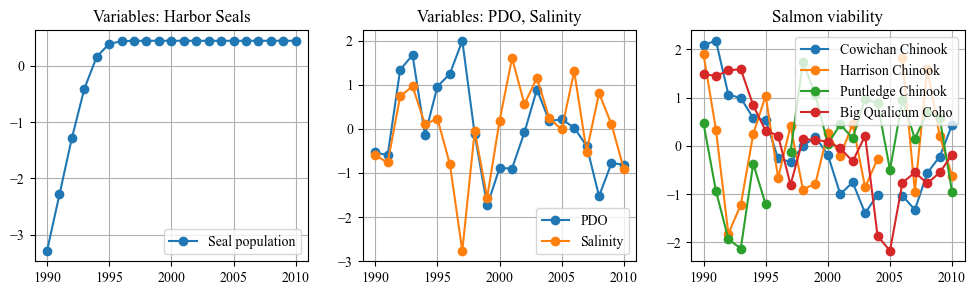

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (12,3))
#Plotting variables vs year
ax1.set_title("Variables: Harbor Seals")
ax1.plot(time_wd,Data_features_pred_nrm,marker = "o",label = 'Seal population')
ax1.legend()
ax1.grid()

#Plotting variables vs year
ax2.set_title("Variables: PDO, Salinity")
ax2.plot(time_wd,Data_features_env_nrm[:,-2],marker = "o",label = 'PDO')
ax2.plot(time_wd,Data_features_env_nrm[:,-1],marker = "o",label = 'Salinity')
ax2.legend()
ax2.grid()

#Plotting salmon viability vs year
ax3.set_title("Salmon viability")
ax3.plot(Salmon_viab_yr,Salmon_viab_nrm[:,0],marker = "o",label = 'Cowichan Chinook')
ax3.plot(Salmon_viab_yr,Salmon_viab_nrm[:,1],marker = "o",label = 'Harrison Chinook')
ax3.plot(Salmon_viab_yr,Salmon_viab_nrm[:,2],marker = "o",label = 'Puntledge Chinook')
ax3.plot(Salmon_viab_yr,Salmon_viab_nrm[:,3],marker = "o",label = 'Big Qualicum Coho')
ax3.legend(loc = 'best')
ax3.grid()

# Viability vs PDO 

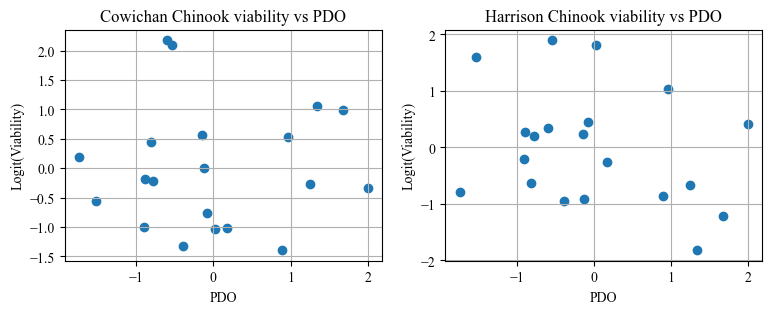

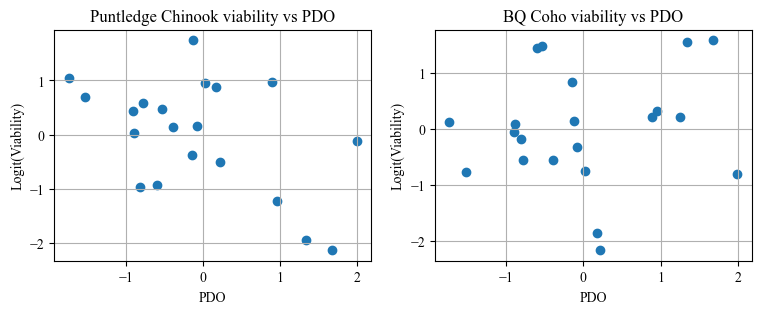

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (9,3))
ax1.set_title("Cowichan Chinook viability vs PDO")
ax1.scatter(Data_features_env_nrm[:,0],Salmon_viab_nrm[:,0])
ax1.set_ylabel("Logit(Viability)")
ax1.set_xlabel("PDO")
ax1.grid()

ax2.set_title("Harrison Chinook viability vs PDO")
ax2.scatter(Data_features_env_nrm[:,0],Salmon_viab_nrm[:,1])
ax2.set_ylabel("Logit(Viability)")
ax2.set_xlabel("PDO")
ax2.grid()

fig, (ax3,ax4) = plt.subplots(1,2,figsize = (9,3))
ax3.set_title("Puntledge Chinook viability vs PDO")
ax3.set_ylabel("Logit(Viability)")
ax3.scatter(Data_features_env_nrm[:,0],Salmon_viab_nrm[:,2])
ax3.set_xlabel("PDO")
ax3.grid()

ax4.set_title("BQ Coho viability vs PDO")
ax4.scatter(Data_features_env_nrm[:,0],Salmon_viab_nrm[:,3])
ax4.set_ylabel("Logit(Viability)")
ax4.set_xlabel("PDO")
ax4.grid()

# Viability vs Salinity

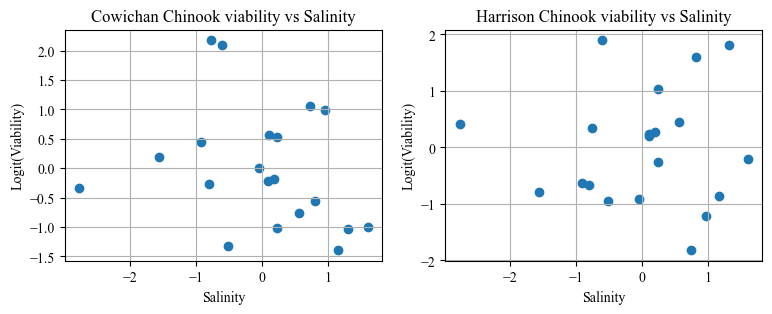

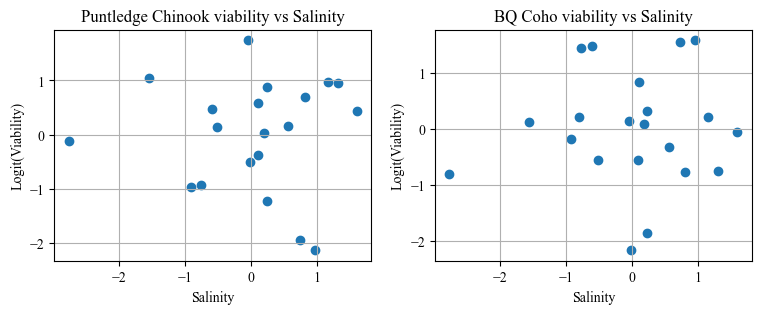

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (9,3))
ax1.set_title("Cowichan Chinook viability vs Salinity")
ax1.scatter(Data_features_env_nrm[:,1],Salmon_viab_nrm[:,0])
ax1.set_ylabel("Logit(Viability)")
ax1.set_xlabel("Salinity")
ax1.grid()

ax2.set_title("Harrison Chinook viability vs Salinity")
ax2.scatter(Data_features_env_nrm[:,1],Salmon_viab_nrm[:,1])
ax2.set_ylabel("Logit(Viability)")
ax2.set_xlabel("Salinity")
ax2.grid()

fig, (ax3,ax4) = plt.subplots(1,2,figsize = (9,3))
ax3.set_title("Puntledge Chinook viability vs Salinity")
ax3.scatter(Data_features_env_nrm[:,1],Salmon_viab_nrm[:,2])
ax3.set_ylabel("Logit(Viability)")
ax3.set_xlabel("Salinity")
ax3.grid()

ax4.set_title("BQ Coho viability vs Salinity")
ax4.scatter(Data_features_env_nrm[:,1],Salmon_viab_nrm[:,3])
ax4.set_ylabel("Logit(Viability)")
ax4.set_xlabel("Salinity")
ax4.grid()

# Viability vs Seal population

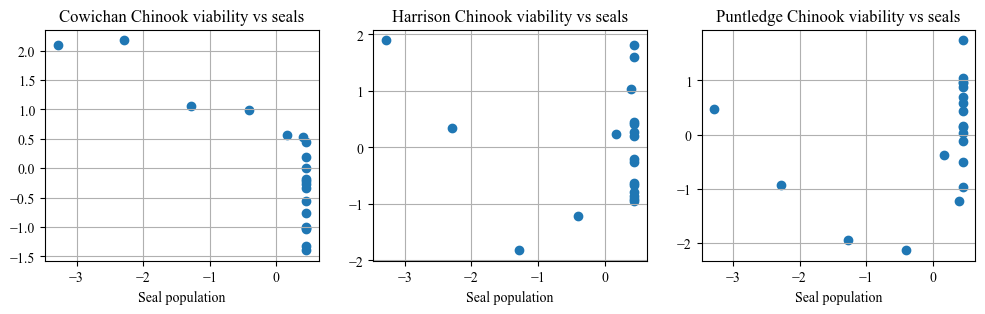

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (12,3))
ax1.set_title("Cowichan Chinook viability vs seals")
ax1.scatter(Data_features_pred_nrm,Salmon_viab_nrm[:,0])
ax1.set_xlabel("Seal population")
ax1.grid()

ax2.set_title("Harrison Chinook viability vs seals")
ax2.scatter(Data_features_pred_nrm,Salmon_viab_nrm[:,1])
ax2.set_xlabel("Seal population")
ax2.grid()

ax3.set_title("Puntledge Chinook viability vs seals")
ax3.scatter(Data_features_pred_nrm,Salmon_viab_nrm[:,2])
ax3.set_xlabel("Seal population")
ax3.grid()